In [1]:
from info import * 
from preprocess import *
import utils

# automatic unit testing: TODO actually automate....
import sys
# sys.path.insert(0, '/Users/matty_gee/Dropbox/Projects/social_navigation_task/tests')
%run -i '../tests/test_behavior.py'

/anaconda3/envs/social_navigation_analysis/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/anaconda3/envs/social_navigation_analysis/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
...........
----------------------------------------------------------------------
Ran 11 tests in 0.443s

OK


In [ ]:

# def by_character(variable):
#     ''' return variable name for each character '''
#     return [variable + '_' + character_roles[c] for c in range(5)]
    

# def chars_df(df, var_name):
#     ''' subset a df with the different character values for a variable'''
#     return df[[var_name + '_' + cr for cr in character_roles]]


# def get_decision_sequence(df):
#     ''' grab decisions from a summary df'''
#     return df.loc[0, ['decisions_' + "{:02d}".format(t+1) for t in range(63)]]


# def repeat_array_cols(X, repeats=2):
#     return np.transpose([X] * repeats)


# Coordinates w/in a trajectory, or across trajectories

In [170]:
cb2.out['current_constant_actual']

,index,responded,affil_decision,power_decision,affil_coord,power_coord,neu_distance,pov_distance,neu2d_angle,neu3d_angle,...,affil_centroid,power_centroid,neu_distance_mean,neu2d_angle_mean,perimeter,area,Q1_overlap,Q2_overlap,Q3_overlap,Q4_overlap
0,0,True,-1.0,0.0,-1.0,0.0,1.000000,7.000000,3.141593,2.070143,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,True,-1.0,0.0,-2.0,0.0,2.000000,8.000000,3.141593,2.111216,...,NaN,NaN,1.500000,3.141593,NaN,NaN,NaN,NaN,NaN,NaN
2,2,True,-1.0,0.0,-3.0,0.0,3.000000,9.000000,3.141593,2.158799,...,NaN,NaN,2.000000,3.141593,NaN,NaN,NaN,NaN,NaN,NaN
3,3,True,0.0,-1.0,-3.0,-1.0,3.162278,9.055386,3.463343,2.176341,...,-2.000000,0.000000,2.290569,3.141593,NaN,NaN,NaN,NaN,NaN,NaN
4,4,True,1.0,0.0,1.0,0.0,1.000000,5.000000,0.000000,1.071450,...,NaN,NaN,1.000000,NaN,5.236068,1.0,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,True,0.0,1.0,-2.0,4.0,4.472136,8.944272,2.034444,2.034444,...,-1.000000,1.000000,2.296691,1.871542,22.708467,30.0,0.302222,0.444444,0.211111,0.042222
59,59,True,0.0,1.0,-3.0,0.0,3.000000,9.000000,3.141593,2.677945,...,-2.000000,-1.100000,2.573604,3.745010,22.797928,32.0,0.293750,0.468750,0.197917,0.039583
60,60,True,0.0,-1.0,-3.0,-1.0,3.162278,9.055386,3.463343,2.690566,...,-2.000000,-0.666667,2.632472,3.675884,22.797928,32.0,0.293750,0.468750,0.197917,0.039583
61,61,True,0.0,1.0,-3.0,0.0,3.000000,9.000000,3.141593,2.976444,...,-2.166667,-1.000000,2.665883,3.652942,22.797928,32.0,0.293750,0.468750,0.197917,0.039583


In [ ]:
# compare the two...
cb = ComputeBehavior(data)
cb.run()
cb.behavior

In [151]:
# TODO: idk the differences btween these
scipy_ch = ConvexHull(cb.coords)
scipy_dl = Delaunay(cb.coords)
from shlex import join
from numpy import asarray
import numpy.lib.recfunctions as rfn
import scipy
from scipy.spatial import ConvexHull, Delaunay, procrustes
from shapely.geometry import Polygon
import pycircstat
import functools

from my_decorators import countCalls
# @countCalls
# @timeit

# TODO speedup: use numpy whenever possible...
# - for the number of rows we are likely to have, numpy arrays are much faster at doing stuff than pandas dataframes...
# TODO speedup: parallelize?
# TODO: think way more about data types and how to opimitize, protect against errors etc...
# TODO: also add in the dtyping way more transparaneyly, cleanly et...
# TODO: more decorators - esp for performance
# TODO: update unittests for this
# TODO: compare aganst previous class
# TODO: need an ANGLE consistency variable...?


class ComputeBehavior2:

    def __init__(self, file, weight_types=False, decision_types=False, coord_types=False, demean_coords=False):
    
        from warnings import simplefilter
        simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # fragmented df...TODO maybe fix??
        np.seterr(divide='ignore', invalid='ignore') # division by 0 in some of our operations
            
        #---------------------------------------------------------------
        # load in data
        #---------------------------------------------------------------
        
        if file is None:

            self.file_path = None
            self.sub_id    = None   

        else:

            if type(file) is not str: # eg for easy unittesting
                
                self.file_path = None
                self.sub_id    = None
                self.data      = copy.deepcopy(file)
            
            else: 
                
                self.file_path = Path(file)
                self.sub_id    = self.file_path.stem.split('_')[1] # expects a filename like 'snt_subid_*'
                if self.file_path.suffix == '.xlsx':  self.data = copy.deepcopy(pd.read_excel(self.file_path, engine='openpyxl'))
                elif self.file_path.suffix == '.xls': self.data = copy.deepcopy(pd.read_excel(self.file_path))
                elif self.file_path.suffix == '.csv': self.data = copy.deepcopy(pd.read_csv(self.file_path))
                else: raise Exception(f'File type {self.file_path.suffix} not recognized')
    
                self.check_input(self.data, (63, self.data.shape[1])) # should have 63 trials
 
            #---------------------------------------------------------------
            # clean up input
            #---------------------------------------------------------------
            
            # get decisions in 2d
            if 'affil' not in self.data.columns: # for backward compatability
                self.data['decision'] = self.data['decision'].astype(int)
                dim_mask  = np.vstack([(self.data['dimension'] == 'affil').values, 
                                       (self.data['dimension'] == 'power').values]).T
                self.data[['affil', 'power']] = self.data['decision'].values[:, np.newaxis] * (dim_mask * 1)
                            
            # ensure correct data types
            type_dict = {'decision_num': int, 'scene_num': int, 'dimension': object,
                         'char_role_num': int, 'char_decision_num': int,
                         'button_press': int, 'decision': int, 'affil': int, 'power': int,
                         'reaction_time': float, 'onset': float}
            for col in self.data: 
                if self.data[col].dtype != type_dict[col]:
                    self.data[col] = self.data[col].astype(type_dict[col])

        #---------------------------------------------------------------
        # what to compute
        #---------------------------------------------------------------
        
        # trajectories: trials for a single character or all trials
        self.trajectories = {}
        for r, role in enumerate(character_roles[0:5]): 
            self.trajectories[role] = np.where(data['char_role_num'] == r + 1)[0]
        self.trajectories['neutral'] = np.where(data['char_role_num'] == 9)[0]

        # types of decisions, weighting, coordinates
        self.decision_types = ['current', 'previous']
        self.weight_types   = ['constant', 'linear', 'exponential']
        self.coord_types    = ['actual', 'counterfactual']

        if decision_types is True:    self.decision_types = ['current', 'previous']
        elif decision_types is False: self.decision_types = ['current']
        else:                         self.decision_types = decision_types
        
        if weight_types is True:    self.weight_types = ['constant', 'linear_decay', 'exponential_decay']
        elif weight_types is False: self.weight_types = ['constant']
        else:                       self.weight_types = weight_types
        
        if coord_types is True:    self.coord_types = ['actual', 'counterfactual']
        elif coord_types is False: self.coord_types = ['actual']
        else:                      self.coord_types = coord_types

        self.demean_coords = demean_coords

    @staticmethod
    def check_input(input, exp_shapes):
        ''' at various points: input to class as well as character specific subsets '''
        if type(exp_shapes) != list: exp_shapes = [exp_shapes]
        matches = np.sum([input.shape == e for e in exp_shapes])
        if matches == 0:
            str_ = (' ').join([f'({e[0]},{e[1]})' for e in exp_shapes])
            raise Exception(f'Shape mismatch: {input.shape}!= any of expected shapes: {str_}')
        else:
            return True

    #---------------------------------------------------------------------------------------
    # defining the trajectories in cartesian and polar coordinates
    #---------------------------------------------------------------------------------------
    
    # where should demeaning fall in here? 
    # can be included in this with everything else...

    @staticmethod
    def get_decisions(decisions_raw, which='current', shift_by=1, replace_with=0, float_dtype='float32'):
        if which == 'current':
            return np.array(decisions_raw, dtype=float_dtype)
        elif which == 'previous':
            decisions_prev = np.ones_like(decisions_raw) * replace_with
            decisions_prev[shift_by:] = np.array(decisions_raw)[0:-shift_by]
            return np.array(decisions_prev, dtype=float_dtype)

    @staticmethod
    def weight_decisions(decisions, weights='constant', float_dtype='float32'):    
        n_trials = len(decisions)
        if weights == 'constant': 
            return np.array(decisions * np.ones(n_trials)[:,None], dtype=float_dtype)
        elif weights == 'linear_decay': 
            return np.array(decisions * utils.linear_decay(1, 1/n_trials, n_trials)[:,None], dtype=float_dtype)
        elif weights == 'exponential_decay': 
            return np.array(decisions * utils.exponential_decay(1, 1/n_trials, n_trials)[:,None], dtype=float_dtype)

    @staticmethod
    def get_coords(decisions, which='actual', float_dtype='float32'):
        if which == 'actual':
            return np.cumsum(decisions, axis=0).astype(float_dtype)
        elif which == 'counterfactual':
            return (np.cumsum(decisions, axis=0) - (2*decisions)).astype(float_dtype)

    @staticmethod
    def make_3d(U, V, ori):
        ''' 
            add 3rd dimension to vector arrays U & V & origin coordinates
            - U are vectors of interest, z-axis will vary w/ number of interactions
            - ori will be subtracted from U, z-axis will vary w/ number of interactions
            - V are reference vectors, z-axis is constant
        '''

        if V.ndim == 2:   V = V[0]
        if ori.ndim == 1: ori = ori[np.newaxis]

        num = np.arange(1, len(U) + 1)[:,np.newaxis]
        U   = np.concatenate([U, num], axis=1) # changes w/ num of interactions
        V   = np.repeat(np.hstack([V, len(U)])[np.newaxis], len(U), axis=0) # fixed
        ori = np.concatenate([np.repeat(ori, len(U), axis=0), num], axis=1) # changes w/ num of interactions   

        return U, V, ori                           
    
    @staticmethod
    def calc_angle(coords, ref_frame, n_dim=2, float_dtype='float32'):
        
        ''' 
            calculate directional angles between (ori to poi) and (ori to ref) [optional 3rd dimension]
            - origin (ori)
            --- neu: (0, 0, [interaction # (1:12)]) - note that 'origin' moves w/ interactions if in 3d
            --- pov: (6, 0, [interaction # (1:12)])
            - reference vector (ref)
            --- neu: (6, 0, [max interaction (12)])
            --- pov: (6, 6, [max interaction (12)])
            - point of interaction vector (poi): (curr. affil coord, power coord, [interaction # (1:12)])
            to get directional vetctors (poi-ori), (ref-ori)
        '''
       
        ref, ori, drn = ref_frame['ref_vec'], ref_frame['origin'], ref_frame['angle_drn']
       
        if n_dim == 3: 
            coords, ref, ori = ComputeBehavior2.make_3d(coords, ref[0], ori)
            drn = None # may not be correct for neutral origin... not sure yet

        return np.array(utils.calculate_angle(coords-ori, ref-ori, force_pairwise=False, direction=drn), dtype=float_dtype)[:, np.newaxis] # maybe add this into this class?

    @staticmethod
    def calc_distance(coords, origin, float_dtype='float32'):
        return np.array([np.linalg.norm(v) for v in coords-origin], dtype=float_dtype)[:, np.newaxis]

    #---------------------------------------------------------------------------------------
    # other geometry
    #---------------------------------------------------------------------------------------

    @staticmethod
    def cumulative(func):
        # decorator to compute measures cumulatively
        # TODO: see if any can do in numpy array instead or at least vstack after but w/in the wrapper
        @functools.wraps(func)
        def wrapper(values):
            return [func(values[:v, :]) for v in range(len(values))]
        return wrapper

    @staticmethod
    def simulate_consistent_decisions(decisions, float_dtype='float32'):
        ''' 
            generate perfectly consistent and perfectly inconsistent decisions given a decision pattern
            - incrementally accounts for non-responses
            - incremental mean: accumulated choices / number of choices made, at each time point
        '''
        resp_mask  = abs(decisions) 
        con_decs   = resp_mask * 1
        incon_decs = np.zeros_like(resp_mask)
        for n_dim in range(2): 
            dim_mask = resp_mask[:, n_dim] != 0 
            incon_decs[dim_mask, n_dim] = [n if not i % 2 else -n for i, n in enumerate(con_decs[dim_mask, n_dim])] # flip every other sign
        return [np.array(incon_decs, dtype=float_dtype), np.array(con_decs, dtype=float_dtype)]

    @staticmethod
    def calc_cumulative_consistency(decisions, float_dtype='float32'):
        
        # simulate possible behavior
        resp_mask = np.abs(decisions)
        [incon_decs, con_decs] = ComputeBehavior2.simulate_consistent_decisions(decisions)  
        min_coords = np.cumsum(incon_decs, axis=0) / np.cumsum(resp_mask, axis=0) # adjust for response counts at each time point
        max_coords = np.cumsum(con_decs, axis=0) / np.cumsum(resp_mask, axis=0)

        # 1d consistency = abs value coordinate, scaled by min and max possible coordinate  
        cum_mean         = ComputeBehavior2.calc_cumulative_tendency(decisions, resp_mask, 'linear')
        consistency_cart = (np.abs(cum_mean) - min_coords) / (max_coords - min_coords) # min max scaled

        # 2d consistency = decision vector length, scaled by min and max possible vector lengths
        min_r, max_r  = (np.array([np.linalg.norm(v) for v in min_coords]), np.array([np.linalg.norm(v) for v in max_coords]))
        cum_mean_r    = np.array([np.linalg.norm(v) for v in cum_mean])
        consistency_r = ((cum_mean_r - min_r) / (max_r - min_r))[:, np.newaxis]
        
        # return both dimensions separately & 2d
        return np.hstack([consistency_cart, consistency_r], dtype=float_dtype) # TODO: think about - not forcing dtype during the actual computation jut at end...

    @staticmethod
    def calc_size(coords, float_dtype="float32"):
        try:
            convexhull = ConvexHull(coords)
            return np.array([convexhull.area, convexhull.volume], dtype=float_dtype) # 2D: perimeter, area, 3D: surface area, volume
        except: 
            return np.array([np.nan, np.nan], dtype=float_dtype)

    @staticmethod
    def calc_polygon(coords):
        # TODO maybe quicker to use all shapely functions
        shape    = ConvexHull(coords) # scipy
        vertices = coords[shape.vertices]
        return geometry.Polygon(vertices) # shapely    

    @staticmethod
    def calc_quadrant_overlap(coords, float_dtype="float32"):
        quads = {'1': np.array([[0,0], [0,6],  [6,0],  [6,6]]),   
                 '2': np.array([[0,0], [0,6],  [-6,0], [-6,6]]),
                 '3': np.array([[0,0], [0,-6], [-6,0], [-6,-6]]), 
                 '4': np.array([[0,0], [0,-6], [6,0],  [6,-6]])}
        try: 
            poly = ComputeBehavior2.calc_polygon(coords)            
            return np.array([poly.intersection(ComputeBehavior2.calc_polygon(qC)).area/poly.area for q, qC in quads.items()], dtype=float_dtype)
        except:
            return np.array([np.nan, np.nan, np.nan, np.nan], dtype=float_dtype)

    @staticmethod
    def calc_centroid(coords, float_dtype='float32'):
        try: 
            return asarray(Polygon(coords).centroid.coords, dtype=float_dtype)
        except: 
            return np.array([np.nan, np.nan], dtype=float_dtype)

    # wrap this in the cumulative decrator too?
    @staticmethod
    def calc_cumulative_mean(values, resp_mask=None, which='linear', float_dtype='float32'):
        # TODO: unittest for same cum mean for decisions wherhter incl. resp_mask or not
        
        if resp_mask is None: resp_mask = np.abs(values)
        if which == 'linear':
            return np.array(np.cumsum(values, axis=0) / 
                            np.cumsum(resp_mask, axis=0), dtype=float_dtype)
        elif which == 'circular':
            means = np.zeros_like(values, dtype=float_dtype)
            for c in range(len(values)):
                if resp_mask[c]: means[c] = pycircstat.mean(values[:c])
                else:            means[c] = means[c-1] # replace w/ previous (or nan?)
            return np.array(means, dtype=float_dtype)

    #---------------------------------------------------------------------------------------
    # run stuff
    #---------------------------------------------------------------------------------------

    @staticmethod
    def calc_trajectory(indices, data, decisions='current', weights='constant', coords='actual', demean_coords=False, float_dtype='float16'):
        
        # TODO better way to do indices?

        # data & response masks
        resp_mask = (data['button_press'] != 0).values[:, np.newaxis]

        # cartesian coordinates
        decisions_raw      = data[['affil', 'power']].values
        decisions_selected = ComputeBehavior2.get_decisions(decisions_raw, which=decisions)
        decisions_weighted = ComputeBehavior2.weight_decisions(decisions_selected, weights=weights) 
        coordinates        = ComputeBehavior2.get_coords(decisions_weighted, which=coords)
        if demean_coords: coordinates = coordinates - np.mean(coordinates, axis=0) # TODO: think about more

        # TODO: polar coordinates - add as a @staticmethod?
        ref_frames = {'neu': {'origin': np.array([[0,0]]), 'ref_vec': np.array([[6,0]]), 'angle_drn': False},
                      'pov': {'origin': np.array([[6,0]]), 'ref_vec': np.array([[6,6]]), 'angle_drn': None}} 
        angles, distances = [], []
        for origin in ['neu', 'pov']:
            distances.append(ComputeBehavior2.calc_distance(coordinates, ref_frames[origin]['origin'])) 
            for n_dim in [2, 3]:
                angles.append(ComputeBehavior2.calc_angle(coordinates, ref_frames[origin], n_dim=n_dim))      

        # TODO: maybe just output structured arrays from the staticmethods?
        trajectory = np.hstack([indices[:,np.newaxis], resp_mask, decisions_weighted, coordinates] + distances + angles)
        trajectory = rfn.unstructured_to_structured(trajectory, np.dtype([('index', 'uint16'), ('responded', 'bool'), ('affil_decision', float_dtype), ('power_decision', float_dtype),
                                                                          ('affil_coord', float_dtype), ('power_coord', float_dtype), ('neu_distance', float_dtype), ('pov_distance', float_dtype),
                                                                          ('neu2d_angle', float_dtype), ('neu3d_angle', float_dtype), ('pov2d_angle', float_dtype), ('pov3d_angle', float_dtype)]))
        return trajectory

    @staticmethod
    def calc_trajectory_measures(indices, trjy, float_dtype='float32'):

        # aliases: 
        unstructure = rfn.structured_to_unstructured
        structure   = rfn.unstructured_to_structured
        cumulative  = ComputeBehavior2.cumulative
        
        # grab decisions & coordinates
        decisions   = unstructure(trjy[['affil_decision','power_decision']])
        coords      = unstructure(trjy[['affil_coord','power_coord']])

        coords_mean  = ComputeBehavior2.calc_cumulative_mean(decisions, which='linear')
        centroid     = np.vstack(cumulative(ComputeBehavior2.calc_centroid)(coords)) 
        dist_mean    = ComputeBehavior2.calc_cumulative_mean(trjy['neu_distance'],trjy['responded'], which='linear')
        angle_mean   = ComputeBehavior2.calc_cumulative_mean(trjy['neu2d_angle'], trjy['responded'], which='circular')

        tjy_measures = np.hstack([indices[:, np.newaxis], coords_mean, centroid, dist_mean[:,np.newaxis], angle_mean[:,np.newaxis]]) # gather each column
        tjy_measures = structure(tjy_measures, np.dtype([('index', 'uint16'), 
                                                         ('affil_mean', float_dtype),        (f'power_mean', float_dtype), 
                                                         ('affil_centroid', float_dtype),    (f'power_centroid', float_dtype),
                                                         ('neu_distance_mean', float_dtype), (f'neu2d_angle_mean', float_dtype)]))     
        return tjy_measures

    @staticmethod
    def calc_shape_measures(indices, coords, float_dtype='float32'):
        cumulative     = ComputeBehavior2.cumulative
        sizes          = np.vstack(cumulative(ComputeBehavior2.calc_size)(coords))
        overlaps       = np.vstack(cumulative(ComputeBehavior2.calc_quadrant_overlap)(coords))
        shape_measures = rfn.unstructured_to_structured(np.hstack([indices[:,np.newaxis], sizes, overlaps]), 
                                                        np.dtype([(f'index', 'uint16'),
                                                                  (f'perimeter', float_dtype), (f'area', float_dtype), 
                                                                  (f'Q1_overlap', float_dtype), (f'Q2_overlap', float_dtype),
                                                                  (f'Q3_overlap', float_dtype), (f'Q4_overlap', float_dtype)]))
        return shape_measures
 

    def run(self, float_dtype='float32'):

        self.out = {}
        types = [[dt, wt, ct] for dt in self.decision_types for wt in self.weight_types for ct in self.coord_types]
        for dt, wt, ct in types:
        
            # compute across trajecotry-specific coordinates:
            trajectories, measures = [], []
            for role, self.ixs in self.trajectories.items():

                data = self.data.loc[self.ixs, ['dimension', 'button_press', 'affil', 'power']]
                trjy = ComputeBehavior2.calc_trajectory(self.ixs, data, decisions=dt, weights=wt, coords=ct, demean_coords=self.demean_coords, float_dtype=float_dtype) # calculate trajectory
                msrs = ComputeBehavior2.calc_trajectory_measures(self.ixs, trjy, float_dtype=float_dtype) # cumulative means, etc
                trajectories.append(trjy)
                measures.append(msrs)

            # concatenate & sort by index (1st col)
            trajectories = np.sort(np.hstack(trajectories))
            measures     = np.sort(np.hstack(measures))

            # calculate summaries of overall space
            self.ixs   = np.arange(0, 63)
            all_coords = rfn.structured_to_unstructured(trajectories[['affil_coord','power_coord']])
            shapes = ComputeBehavior2.calc_shape_measures(self.ixs, all_coords, float_dtype=float_dtype)   
            
            # TODO: add a whole task trajecotry, trajectory measures and space measures
            # grand_trajectories = ComputeBehavior2.calc_trajectory_measures(trajectories)
            # if reset indices and rerun calc_trajectory, will ignore the character specific assumptions...

            # output
            # TODO: out = join_struct_arrays([measures, shapes]) # not doing exactly what I want....
            self.out[f'{dt}_{wt}_{ct}'] = merge_dfs([pd.DataFrame(trajectories), pd.DataFrame(measures), pd.DataFrame(shapes)])


data = pd.read_excel(example_org_file)
cb2   = ComputeBehavior2(data, demean_coords=True)
cb2.run()


# shapely_poly = Polygon(cb.coords)
# shapely_ch   = shapely_poly.convex_hull # only works in 2d....

# # give same answer:
# print(scipy_ch.volume) # In 2d this should be area
# print(shapely_ch.area)

# TODO: figure out
# scipy.spatial.procrustes
# poly.normalize() #?
# shapely_poly.boundary

5.499999999999999
5.5


# Visualize the different decision weighting schemes...

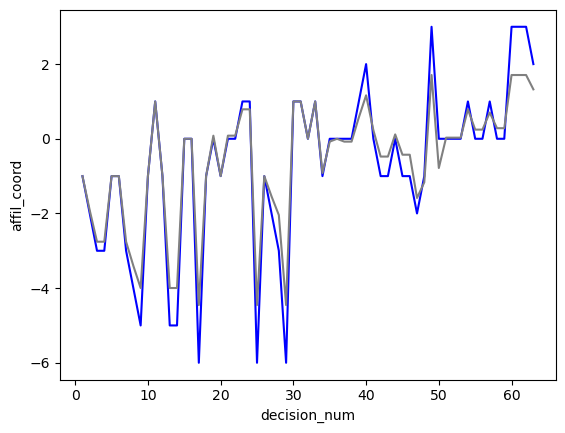

In [68]:
import seaborn as sns
# plot against time
sns.lineplot(data=behavior, x="decision_num", y="affil_coord", color='blue')
# sns.lineplot(data=behavior, x="decision_num", y="affil_coord_cf", color='grey')
sns.lineplot(data=behavior, x="decision_num", y="affil_coord_exponential-decay", color='grey')
# sns.lineplot(data=behavior, x="decision_num", y="power_coord", color='red')
plt.show()